### Project B

1. Communities of users (maybe checking correlation with genres of the movies)
2. Difference between critics score (Metascore and something european) and general public (from our database) of the 50 most rated movies
3. Sentiment analysis of the tags given to each movie, and check if there is a correlation between the sentiment score and the rating the movie was give

In [1]:
import community
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import os
import powerlaw
import pandas as pd
import urllib.request
import requests
from urllib.parse import quote
from fa2 import ForceAtlas2
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

In [2]:
# Functin to download file from github
def file_exist(file_name):
    return file_name in os.listdir(os.getcwd())
def download_file(url,file_name):
    if file_exist(file_name):
        return
    response = requests.get(url)
    open(file_name, "wb").write(response.content)

In [3]:
# Load the dataset from git
url = "https://raw.githubusercontent.com/sifat-e-noor/Project-assignment-A-Movie-dataset-/main/movies.csv"
download_file(url,"movies.csv")
# Create movies dataframe
df_movie = pd.read_csv("movies.csv")
# df_movie.head(10)

In [4]:
# Load the dataset from git
url = "https://raw.githubusercontent.com/sifat-e-noor/Project-assignment-A-Movie-dataset-/main/ratings.csv"
download_file(url,"ratings.csv")
# Create ratings dataframe
df_ratings = pd.read_csv("ratings.csv")
df_ratings.head(10)
# Pick only userId from df_ratings
df_ratings_onlyuserid = df_ratings.drop(df_ratings.loc[:, 'movieId':'timestamp'].columns, axis=1)
df_ratings_onlyuserid

,userId
0,1
1,1
2,1
3,1
4,1
...,...
100831,610
100832,610
100833,610
100834,610


In [5]:
# Load the dataset from git
url = "https://raw.githubusercontent.com/sifat-e-noor/Project-assignment-A-Movie-dataset-/main/links.csv"
download_file(url,"links.csv")
# Create links dataframe
df_links = pd.read_csv("links.csv")
# df_links.head(10)

In [6]:
# Load the dataset from git
url = "https://raw.githubusercontent.com/sifat-e-noor/Project-assignment-A-Movie-dataset-/main/tags.csv"
download_file(url,"tags.csv")
# Create tags dataframe
df_tags = pd.read_csv("tags.csv")
df_tags.head(10)
# Pick only userId from df_tags
df_tags_onlyuserid = df_tags.drop(df_tags.loc[:, 'movieId':'timestamp'].columns, axis=1)
df_tags_onlyuserid

,userId
0,2
1,2
2,2
3,2
4,2
...,...
3678,606
3679,606
3680,610
3681,610


In [7]:
# Merge df_ratings and df_tags
df_frames = [df_ratings_onlyuserid, df_tags_onlyuserid]  
df_frames = pd.concat(df_frames)

# Find unique userId(s) from df_frames 
df_unique_userId = df_frames['userId'].unique()
# df_unique_userId
# print(f"Unique userId(s) from ratings and tags dataframes: \n {df_frames['userId'].unique()}")

In [8]:
# Create users_watched_common_generes_movies graph (denotes with G) and add userId(s) as nodes 
G = nx.Graph()
G.add_nodes_from(df_unique_userId)
# G.number_of_nodes()
# G.edges.data()

In [9]:
# Find common_movies as edges attribute
# Get movieId for each unique userId from df_tags and df_ratings
dict_moviedId = {}
def user_watched_movie(userId): 
    movieId_from_ratings = df_ratings["movieId"].where(df_ratings["userId"]==userId).dropna()
    movieId_from_tags = df_ratings["movieId"].where(df_ratings["userId"]==userId).dropna()
    data = [ movieId_from_ratings, movieId_from_tags]
    df_user_watched_movies = set(pd.concat(data, axis = 0))
    return df_user_watched_movies

for userId in df_unique_userId:
    dict_moviedId[userId] = user_watched_movie(userId)

In [10]:
# Find common_movies_genres as edges attribute
# Get movie_geners for each unique movieId from df_movie
def getGenreFromMovies(common_movies):
    movie_genre_data = set()
    for movieId in common_movies:
        movie_genre = df_movie["genres"].where(df_movie["movieId"]==movieId).dropna() 
        movie_genre_split = movie_genre.values[0].split("|")
        movie_genre_data.update(movie_genre_split)
    return movie_genre_data

In [11]:
# Add the edges common_movies and common_movies_genres
dict_moviedId_keys = list(dict_moviedId.keys())
for i in range(0, len(dict_moviedId_keys)):
    for j in range(i+1, len(dict_moviedId_keys)):
        node1 = dict_moviedId_keys[i]
        node2 = dict_moviedId_keys[j]
        common_movies = dict_moviedId[node1].intersection(dict_moviedId[node2])
        genre = getGenreFromMovies(common_movies)
        if len(common_movies) > 0:
#             print("edge exist")
            G.add_edge(node1, node2, common_movies = common_movies, genre=genre) 
#         print(common_movies)

In [12]:
# View nodes and edges data/attributes
# G.edges.data()

In [13]:
# Print the no. of nodes and edges of users_watched_common_generes_movies
print("Nodes:",G.number_of_nodes(), " edges:", G.number_of_edges())

Nodes: 610  edges: 164054


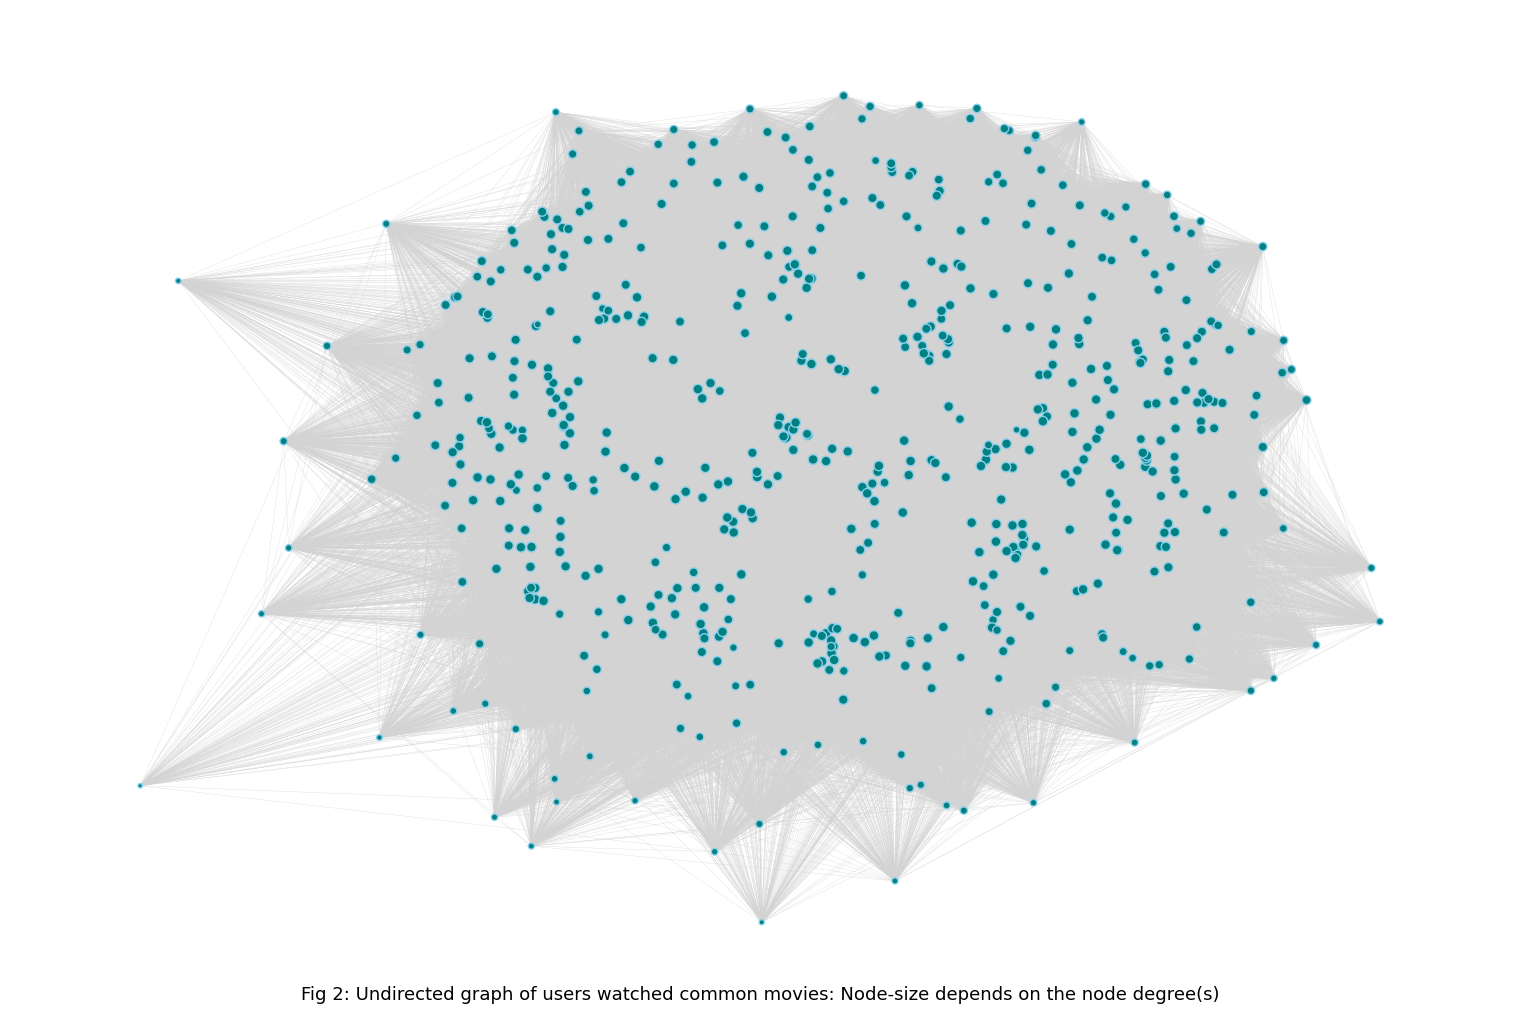

In [15]:
# Draw the undirected graph of users_watched_common_generes_movies universe where node-size depends on the node degree
dict_G_degree = dict(G.degree)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, edge_color='lightgray',edgecolors='skyblue', node_color="teal", with_labels=False, nodelist=list(dict_G_degree.keys()), node_size=[v * .08 for v in list(dict_G_degree.values())], width=.2)
plt.figtext(0.5, 0.01,'Fig 1: Undirected graph of users watched common movies: Node-size depends on the node degree(s)', wrap=True, horizontalalignment='center', fontsize=13) 
plt.show()

In [16]:
# Find users_watched_common_genres_movies universe communities
users_watched_common_genre_movies_communities = nx_comm.louvain_communities(G, seed=123)
# print(users_watched_common_movies_communities)

# Count the communities of users_watched_common_genres_movies universe
print(f"The users watched common movies universe has {len(users_watched_common_genre_movies_communities)} communities. \n")
nx_best_communities = tuple(sorted(c) for c in users_watched_common_genre_movies_communities)
print('Best communities:')
print(f'Community 1:\n {nx_best_communities[0]},\n Community 2:\n {nx_best_communities[1]},\n Community 3:\n{nx_best_communities[2]}')

The users watched common movies universe has 3 communities. 

Best communities:
Community 1:
 [5, 6, 7, 8, 11, 14, 17, 23, 24, 26, 27, 29, 31, 32, 33, 35, 37, 38, 39, 40, 43, 44, 46, 54, 56, 58, 59, 61, 71, 72, 78, 81, 82, 86, 90, 93, 94, 96, 99, 100, 102, 107, 109, 110, 112, 115, 116, 117, 118, 120, 121, 122, 124, 128, 129, 130, 133, 134, 136, 141, 142, 144, 145, 146, 149, 150, 151, 155, 162, 164, 170, 171, 172, 173, 174, 176, 179, 181, 183, 191, 192, 195, 196, 197, 201, 206, 208, 214, 223, 229, 234, 235, 240, 242, 243, 244, 254, 259, 262, 264, 265, 266, 267, 269, 270, 273, 276, 277, 279, 283, 284, 287, 293, 297, 301, 302, 303, 314, 321, 323, 329, 335, 336, 337, 340, 341, 347, 349, 350, 353, 355, 359, 361, 364, 373, 374, 375, 376, 379, 384, 385, 386, 389, 394, 395, 396, 402, 404, 405, 411, 423, 429, 436, 437, 444, 445, 446, 450, 451, 455, 456, 457, 458, 463, 464, 465, 467, 468, 470, 476, 478, 482, 485, 486, 488, 492, 493, 494, 498, 500, 501, 507, 510, 512, 513, 516, 521, 524, 527, 529

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.03it/s]


BarnesHut Approximation  took  0.14  seconds
Repulsion forces  took  0.97  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.44  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


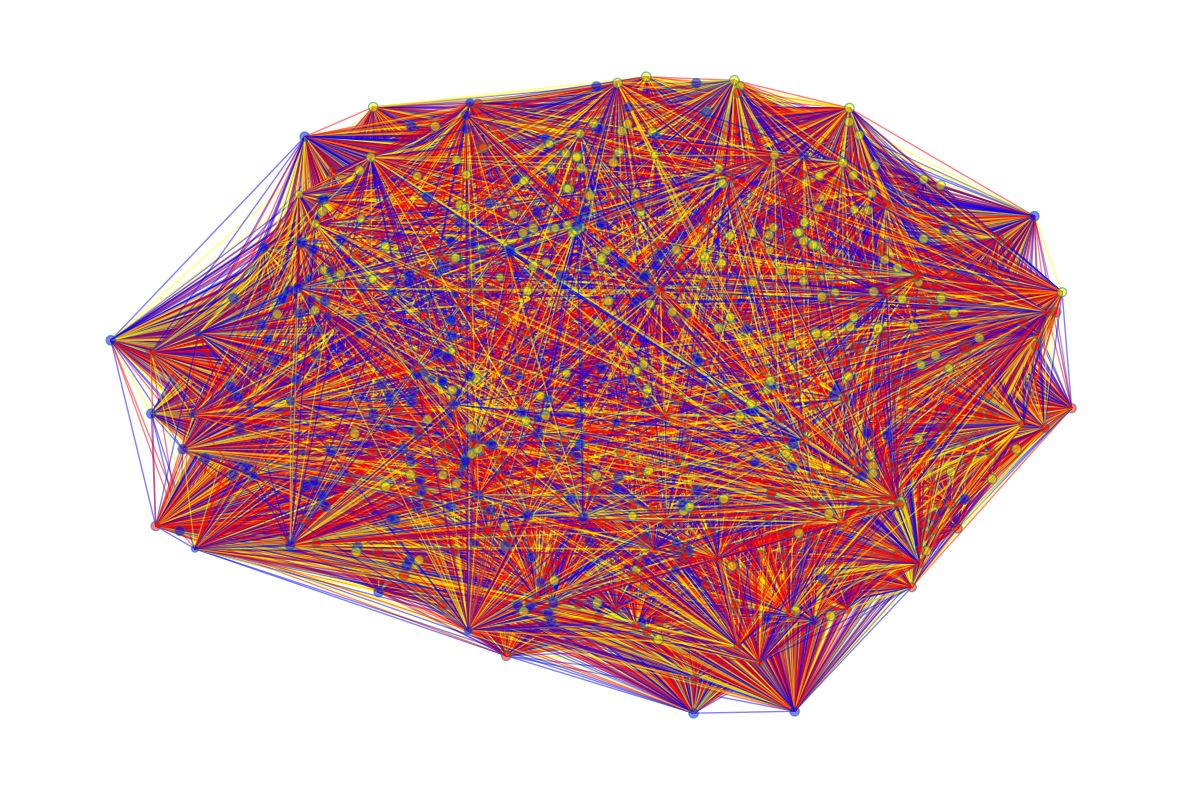

<Figure size 60000x60000 with 0 Axes>

In [17]:
# Plot the undirected graph of users_watched_common_genre_movies_comm universe using the Force Atlas algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.000001,
                          strongGravityMode=False,
                          gravity=0.000001,

                          # Log
                          verbose=True)

color_map_nodes = []
color_map_edges = []
for node in G:
    if node in nx_best_communities[0]:
        color_map_nodes.append("red")
        color_map_edges.append("red")
    elif node in nx_best_communities[1]:
        color_map_nodes.append("blue")
        color_map_edges.append("blue")    
    else:
        color_map_nodes.append("yellow")
        color_map_edges.append("yellow")
        
        
dict_G_degree_1 = dict(G.degree)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
nx.draw_networkx(G, positions, node_color=color_map_nodes, edge_color=color_map_edges, node_size=[v * .08 for v in dict_G_degree_1.values()], edgecolors='teal', with_labels=False, alpha=0.5)
plt.axis('off')
plt.figure(3,figsize=(1000,1000), dpi=60) 
plt.figtext(0.5, 0.01,'Fig 2: Visual of undirected graph of users watched common genre movies communities universe using Force Atlas', wrap=True, horizontalalignment='center', fontsize=13) 
plt.show()

In [18]:
# Create subgraph of best communities  
H1 = G.subgraph(nx_best_communities[0])
H2 = G.subgraph(nx_best_communities[1])
H3 = G.subgraph(nx_best_communities[2])
# H.number_of_nodes()

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 487.92it/s]


BarnesHut Approximation  took  0.06  seconds
Repulsion forces  took  0.23  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


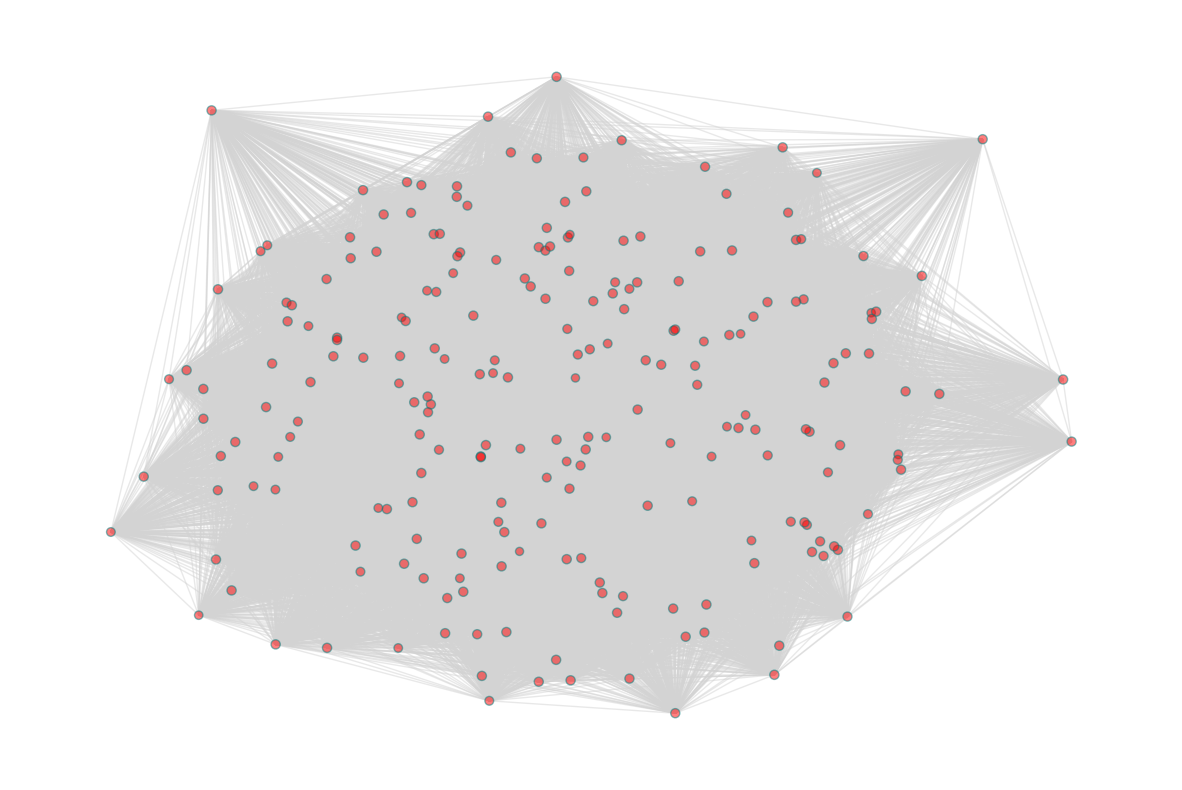

<Figure size 60000x60000 with 0 Axes>

In [19]:
# Plot the undirected graph of users_watched_common_movies universe using the Force Atlas algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.000001,
                          strongGravityMode=False,
                          gravity=0.000001,

                          # Log
                          verbose=True)

        
        
dict_H_degree = dict(H1.degree)
positions = forceatlas2.forceatlas2_networkx_layout(H1, pos=None, iterations=200)
nx.draw_networkx(H1, positions, node_color="red", edge_color="lightgray", node_size=[v * .2 for v in dict_H_degree.values()], edgecolors='teal', with_labels=False, alpha=0.5)
plt.axis('off')
plt.figure(3,figsize=(1000,1000), dpi=60) 
plt.figtext(0.5, 0.01,'Fig 3: Visual of undirected graph of community 1 users watched common movies universe using Force Atlas', wrap=True, horizontalalignment='center', fontsize=13) 
plt.show()

In [20]:
# Find the most frequent genres of common movies watched by community 1 users
from collections import defaultdict
# Define the defaultdict
genre_dict = defaultdict(int)
for edge in H1.edges.data():
    genres = edge[2]['genre']
    for genre in genres:
        genre_dict[genre] += 1
    
dictionary_keys = sorted(list(dict.keys(genre_dict)), reverse=True)
sorted_dict = {dictionary_keys[i]: sorted(dict.values(genre_dict),reverse=True)[i] for i in range(len(dictionary_keys))}
print('\f The most frequent genres of common movies watched by community 1 users:')
sorted_dict 

 The most frequent genres of common movies watched by community 1 users:


{'Western': 21544,
 'War': 20544,
 'Thriller': 20289,
 'Sci-Fi': 19862,
 'Romance': 19087,
 'Mystery': 17594,
 'Musical': 17442,
 'IMAX': 15556,
 'Horror': 13419,
 'Film-Noir': 10738,
 'Fantasy': 10697,
 'Drama': 10628,
 'Documentary': 8919,
 'Crime': 8565,
 'Comedy': 8386,
 'Children': 6842,
 'Animation': 6457,
 'Adventure': 271,
 'Action': 91}

In [21]:
# Find the most frequent genres of common movies watched by community 2 users
from collections import defaultdict
# Define the defaultdict
genre_dict2 = defaultdict(int)
for edge in H2.edges.data():
    genres = edge[2]['genre']
    for genre in genres:
        genre_dict2[genre] += 1
    
dictionary_keys2 = sorted(list(dict.keys(genre_dict2)), reverse=True)
sorted_dict2 = {dictionary_keys[i]: sorted(dict.values(genre_dict2),reverse=True)[i] for i in range(len(dictionary_keys))}
print('\f The most frequent genres of common movies watched by community 2 users:')
sorted_dict2 

 The most frequent genres of common movies watched by community 2 users:


{'Western': 17688,
 'War': 17531,
 'Thriller': 15963,
 'Sci-Fi': 15648,
 'Romance': 15282,
 'Mystery': 15220,
 'Musical': 14494,
 'IMAX': 14161,
 'Horror': 13461,
 'Film-Noir': 12636,
 'Fantasy': 11560,
 'Drama': 11224,
 'Documentary': 11087,
 'Crime': 10130,
 'Comedy': 9808,
 'Children': 6791,
 'Animation': 6594,
 'Adventure': 5077,
 'Action': 2095}

In [22]:
# Find the most frequent genres of common movies watched by community 3 users
from collections import defaultdict
# Define the defaultdict
genre_dict3 = defaultdict(int)
for edge in H3.edges.data():
    genres = edge[2]['genre']
    for genre in genres:
        genre_dict3[genre] += 1
    
dictionary_keys = sorted(list(dict.keys(genre_dict3)), reverse=True)
sorted_dict3 = {dictionary_keys[i]: sorted(dict.values(genre_dict3),reverse=True)[i] for i in range(len(dictionary_keys))}
print('\f The most frequent genres of common movies watched by community 3 users:')
sorted_dict3 

 The most frequent genres of common movies watched by community 3 users:


{'Western': 14449,
 'War': 13612,
 'Thriller': 12636,
 'Sci-Fi': 12632,
 'Romance': 11672,
 'Mystery': 11607,
 'Musical': 10976,
 'IMAX': 9688,
 'Horror': 8920,
 'Film-Noir': 8111,
 'Fantasy': 7829,
 'Drama': 7708,
 'Documentary': 5957,
 'Crime': 5834,
 'Comedy': 4581,
 'Children': 1447,
 'Animation': 967,
 'Adventure': 466,
 'Action': 259,
 '(no genres listed)': 7}

In [23]:
# Create dataframe of most frequent genres of common movies watched by communities users
new_df_list = [sorted_dict, sorted_dict2, sorted_dict3]
df_communities_common_genres_movies = pd.DataFrame(new_df_list, index=['Community1', 'Community2', 'Community3'])
df_communities_common_genres_movies

,Western,War,Thriller,Sci-Fi,Romance,Mystery,Musical,IMAX,Horror,Film-Noir,Fantasy,Drama,Documentary,Crime,Comedy,Children,Animation,Adventure,Action,(no genres listed)
Community1,21544,20544,20289,19862,19087,17594,17442,15556,13419,10738,10697,10628,8919,8565,8386,6842,6457,271,91,NaN
Community2,17688,17531,15963,15648,15282,15220,14494,14161,13461,12636,11560,11224,11087,10130,9808,6791,6594,5077,2095,NaN
Community3,14449,13612,12636,12632,11672,11607,10976,9688,8920,8111,7829,7708,5957,5834,4581,1447,967,466,259,7.0


In [24]:
# Create a directed graph form G for degree distributions 
Dig_grapgh = G.to_directed()

In [25]:
# Plotting the degree distribution of the network

def plot_d(Dig_grapgh, scale='lin', alpha=1, colour='black'):
    
    num_nodes = Dig_grapgh.number_of_nodes()
    m_degree = 0
    
    for n in Dig_grapgh.nodes():
        if Dig_grapgh.degree(n) > m_degree:
            m_degree = Dig_grapgh.degree(n)
#    print(maximum_degree)

    x = []
    y_ = []
    
    for j in range(m_degree + 1):
        x.append(j)
        y_.append(0)
        for n in Dig_grapgh.nodes():
            if Dig_grapgh.degree(n) == j:
                y_[j] += 1
        y = [j / num_nodes for j in y_] 
    
    
    # Plotting the degree distributions for the network using linear and log-log axes.
    
    #linear
    if scale == 'linear':
        plt.xscale('linear')
        plt.yscale('linear')
        plt.ylabel('count')
        plt.xlabel('k')
        plt.figtext(0.5, 0.07,'Fig 4: Degree distribution - linear scale', wrap=True, horizontalalignment='center', fontsize=12)
        plt.plot(x, y, linewidth = 0, marker = '.', markersize = 10, color = 'slategrey', alpha = alpha)
    
    #log
    if scale == 'log':
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('count')
        plt.xlabel('k')
        plt.figtext(0.5, 0.07,'Fig 5: Degree distribution - log scale', wrap=True, horizontalalignment='center', fontsize=12)
        plt.plot(x, y, linewidth = 0, marker = '.', markersize = 10, color = 'slategrey', alpha = alpha)
        
    else:
        pass
    
    plt.show()    

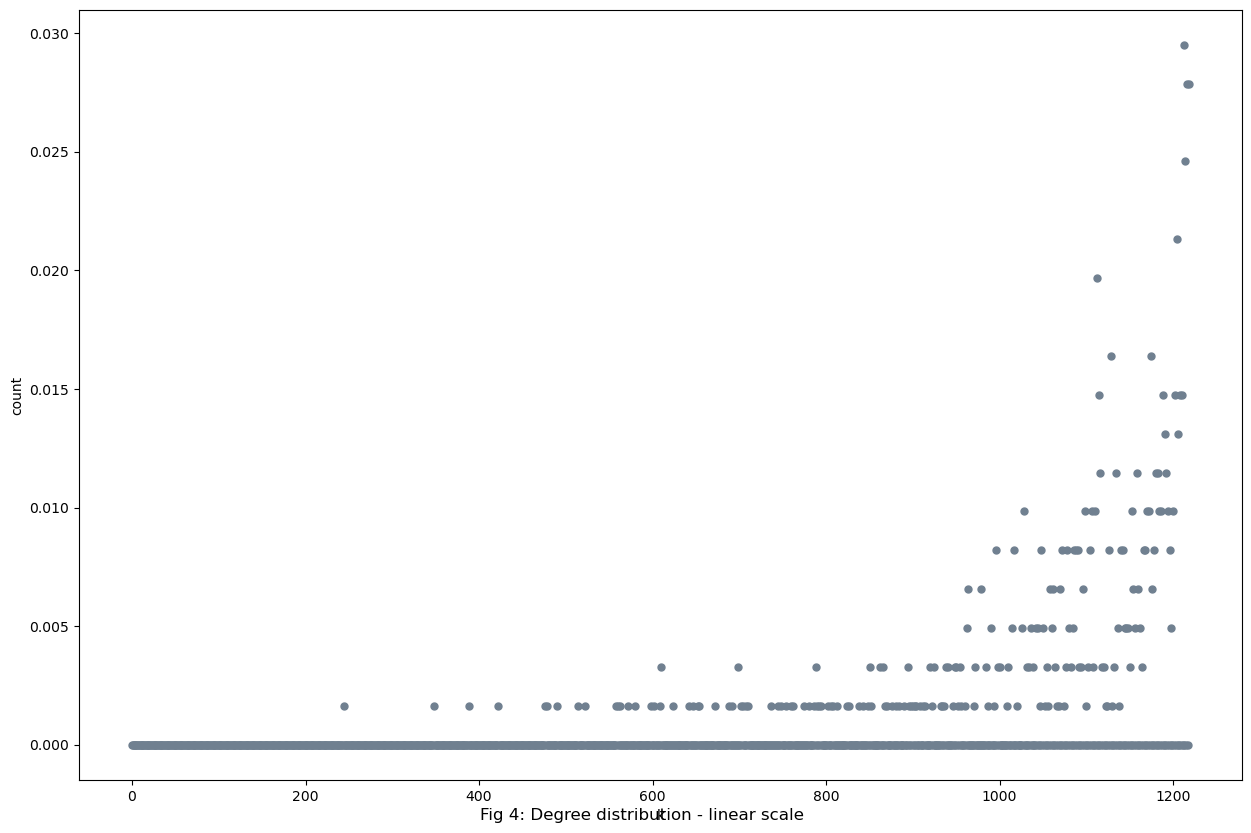

In [26]:
plot_d(Dig_grapgh, scale = 'linear')

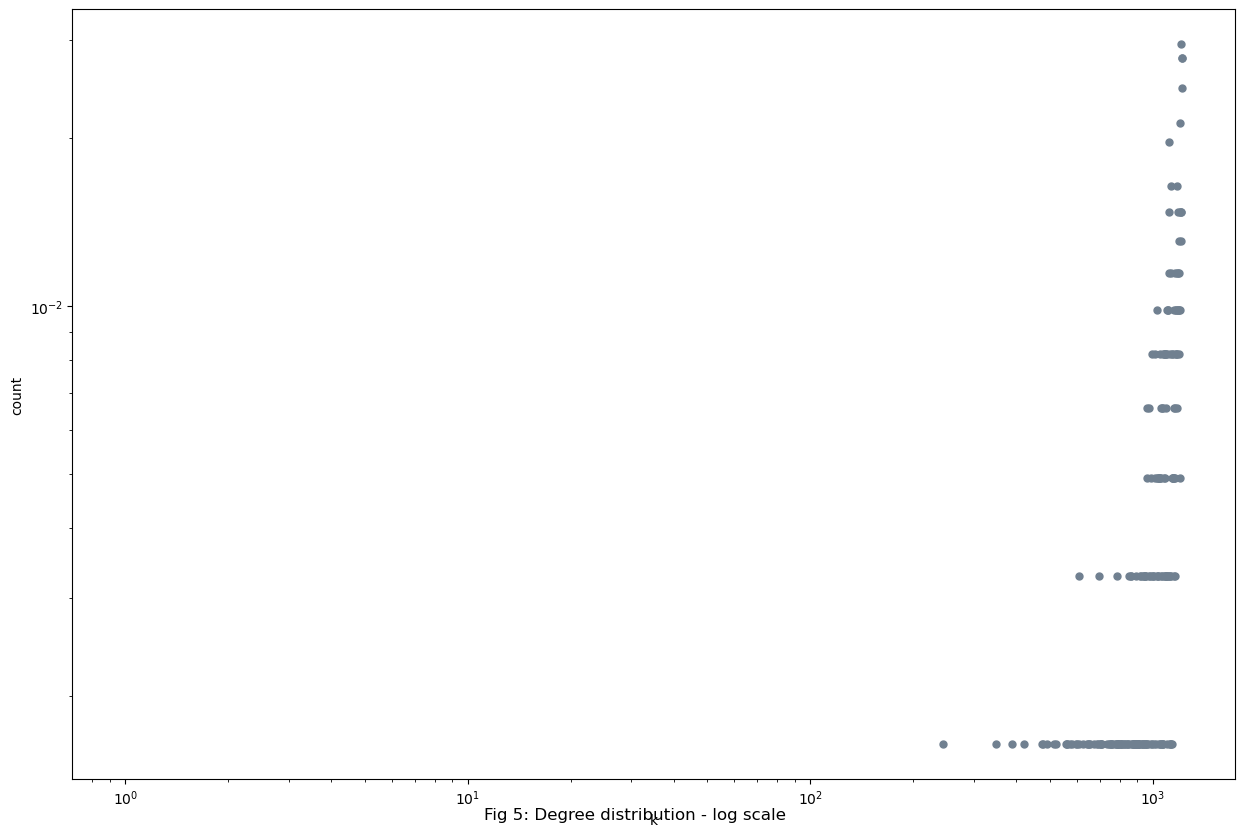

In [27]:
plot_d(Dig_grapgh, scale = 'log')

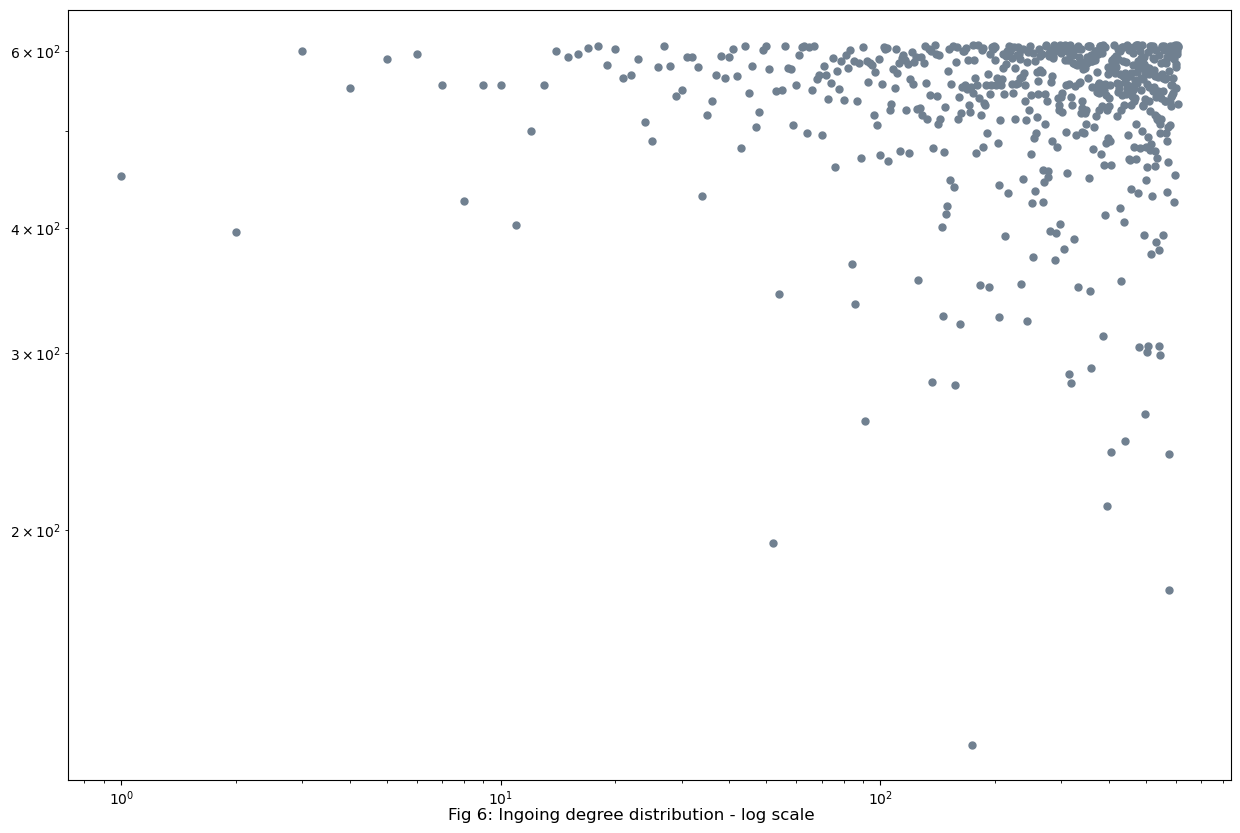

In [28]:
# Create the ingoing degree distributions
indegrees = pd.DataFrame(Dig_grapgh.in_degree(), columns=['Node', 'Degree'])
indegreeslog = [Dig_grapgh.in_degree(n) for n in Dig_grapgh.nodes()]
plt.xscale('log')
plt.yscale('log')
plt.plot(indegrees['Degree'], linewidth = 0, marker = '.', markersize = 10, color = 'slategrey')
plt.figtext(0.5, 0.07,'Fig 6: Ingoing degree distribution - log scale', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

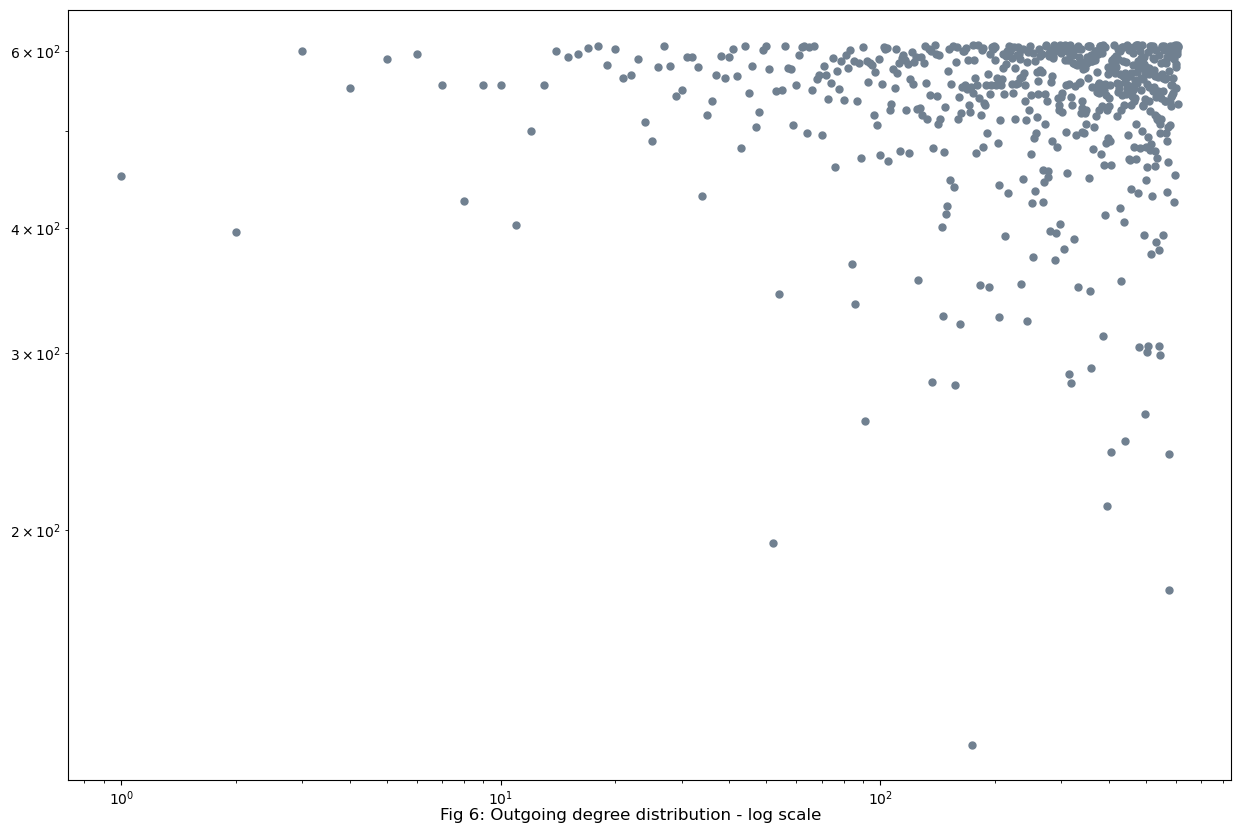

In [29]:
# Creating the outgoing degree distributions
outdegrees = pd.DataFrame(Dig_grapgh.out_degree(), columns=['Node', 'Degree'])
outdegreeslog = [Dig_grapgh.out_degree(n) for n in Dig_grapgh.nodes()]
plt.xscale('log')
plt.yscale('log')
plt.plot(outdegrees['Degree'], linewidth = 0, marker = '.', markersize = 10, color = 'slategrey')
plt.figtext(0.5, 0.07,'Fig 6: Outgoing degree distribution - log scale', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [31]:
# Estimate the slope of the incoming degree distribtion
deg = {}

for x in list(Dig_grapgh.nodes()):
    key = len(list(Dig_grapgh.neighbors(x)))
    deg[key] = deg.get(key, 0) + 1

max_deg = max(deg.keys(), key=int)

degrees = []

for y in range(1, max_deg + 1):
    degrees.append(deg.get(y, 0))

fit = powerlaw.Fit(degrees)
print("Estimation of the slope of the incoming degree distribution:")
print(fit.power_law.alpha)

Estimation of the slope of the incoming degree distribution:
4.009841680339939


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
